In [3]:
import math
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt

In [4]:
### tools：

def minfunction(f, x0, bounds):
    """
    求一个函数在边界内的最小值
    f：函数
    x0：初始值
    bounds：边界条件。[(min, max),...]
    """
    res = minimize(f, x0, method='SLSQP', bounds=bounds)
    return res

def maxfunction(f, x0, bounds):
    """
    求一个函数在边界内的最大值
    f：函数
    x0：初始值
    bounds：边界条件。[(min, max),...]
    """
    fun = lambda X : -f(X)
    res = minimize(fun, x0, method='SLSQP', bounds=bounds)
    return res


In [5]:
### 目标函数：
bounds = [(0,300),(0,300),(0,100),(0,200),(0,100),(0,300),(0,100),(0,200),(0.01,0.03)]
x_opt = [0.00510000000000259465, 99.9947000000000514, 9.01920162996045897e-18, 99.9999000000000535, 
         0.000100000000027086086, 2.75700683389584542e-14, 99.9999999999999574, 200, 0.0100000100000100008]
y_opt = -400.055099999999584
def G23(X):
    
    y = -9*X[4]-15*X[7]+6*X[0]+16*X[1]+10*(X[5]+X[6])
    
    g1 = X[8]*X[2]+0.02*X[5]-0.025*X[4]
    g2 = X[8]*X[3]+0.02*X[6]-0.015*X[7]
    
    h1 = abs(X[0]+X[1]-X[2]-X[3])-0.0001
    h2 = abs(0.03*X[0]+0.01*X[1]-X[8]*(X[2]+X[3]))-0.0001
    h3 = abs(X[2]+X[5]-X[4])-0.0001
    h4 = abs(X[3]+X[6]-X[7])-0.0001
    
    return y,g1,g2,h1,h2,h3,h4

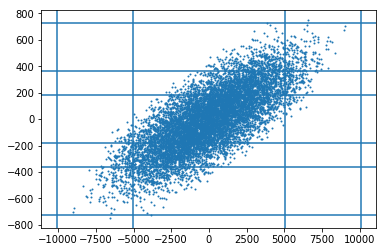

In [11]:
pN = 100
dim = 9
keth = 0.5
eta = 0.5
X = np.zeros((pN, dim))
for i in range(pN):
    for j in range(dim):
        X[i][j] = bounds[j][0]+(bounds[j][1]-bounds[j][0])*np.random.random()

fs = []    
Vs = []
for i in range(pN):
    for j in range(pN):
        if i != j:
            deltaf = G23(X[i])[0] - G23(X[j])[0]
            delraV = np.sum(G23(X[i])[1:7])-np.sum(G23(X[j])[1:7])
            fs.append(deltaf)
            Vs.append(delraV)

plt.scatter(fs,Vs,s=1)
plt.axhline(y=728.9996997181571, xmin=-10100, xmax=10100)
plt.axhline(y=-728.9996997181571, xmin=-10100, xmax=10100)
plt.axhline(y=728.9996997181571*keth, xmin=-10100, xmax=10100)
plt.axhline(y=-728.9996997181571*keth, xmin=-10100, xmax=10100)
plt.axhline(y=728.9996997181571*keth*eta, xmin=-10100, xmax=10100)
plt.axhline(y=-728.9996997181571*keth*eta, xmin=-10100, xmax=10100)

plt.axvline(x=10100, ymin=-728.9996997181571, ymax=728.9996997181571)
plt.axvline(x=-10100, ymin=-728.9996997181571, ymax=728.9996997181571)
plt.axvline(x=10100*eta, ymin=-728.9996997181571, ymax=728.9996997181571)
plt.axvline(x=-10100*eta, ymin=-728.9996997181571, ymax=728.9996997181571)
plt.show()

In [4]:
# y = lambda X: G23(X)[0]

# g1 = lambda X: G23(X)[1]
# g2 = lambda X: G23(X)[2]
# h1 = lambda X: G23(X)[3]
# h2 = lambda X: G23(X)[4]
# h3 = lambda X: G23(X)[5]
# h4 = lambda X: G23(X)[6]
# x0 = [0,0,0,0,0,0,0,0,0.01]

In [5]:
# maxfunction(h4,x0,bounds)

In [6]:
# 8.999999993745742+8.0+11.999899724411286+399.9999+299.9999

In [7]:
# G23(x_opt)

In [8]:
### 适应度函数
def fitnessG23_num(X):
    """
    problem1关于数量惩罚的适应度函数
    X: 对应的解
    epsion：惩罚系数大于fmax-fmin的倍数
    """
    fmax = 1220.174
    fmin = 0.008509619375000003
    count = np.sum(np.array(problem1(X))[1:5]>0)
    
    return -(problem1(X)[0]+epsion*(fmax-fmin)*count)  

def fitnessG23_vio(X):
    """
    problem1关于数量惩罚的适应度函数
    X: 对应的解
    epsion：惩罚系数大于fmax-fmin的倍数
    """
    fmax = 10600.0
    fmin = 3900.0
    vmax = 728.9996997181571
    e = 0.0001
    n = 6
    
    res = G23(X)
    fitness = -res[0]
    count = np.sum(np.array(res)[1:7]>0)
    
    
    if count > 0:
        for i in range(1,len(res)):
            if res[i] > 0:
                cathy = (fmax - fmin)*(e*vmax*n/count+res[i])/(e*vmax)
                fitness = fitness - cathy

    return fitness   


In [9]:
### PSO
class PSO_fit():
    def __init__(self, pN, dim, max_iter, bounds):
        self.wmax = 0.8 #最大的惯性权重
        self.wmin = 0.4 #最小的惯性权重
        self.c1 = 2  #加速因子
        self.c2 = 2  #加速因子
        self.pN = pN  # 粒子数量
        self.dim = dim  # 搜索维度
        self.max_iter = max_iter  # 迭代次数
        self.bounds = bounds
        
        self.X = np.zeros((self.pN, self.dim))  # 所有粒子的位置：一个pN*dim的矩阵
        self.V = np.zeros((self.pN, self.dim))  # 左右粒子的速度：一个pN*dim的矩阵
        self.pbest = np.zeros((self.pN, self.dim))  # 个体经历的最佳位置：一个pN*dim的矩阵
        self.gbest = np.zeros((self.pN, self.dim))      # 全局最佳位置：一个pN*dim的矩阵
        self.p_fit = np.full(self.pN,-10.0e+28)  # 每个个体的历史最佳适应值
        self.g_fit = np.full(self.pN,-10.0e+28)    # 全局最佳适应值
    
    def init_Population(self):
        """
        初始化种群
        :return:
        """
        
        for i in range(self.pN):
            for j in range(self.dim):
                self.X[i][j] = self.bounds[j][0] + (self.bounds[j][1] - self.bounds[j][0]) * np.random.random()
                self.V[i][j] = self.bounds[j][0] + (self.bounds[j][1] - self.bounds[j][0]) * np.random.random()
        for i in range(self.pN):
            tmp = fitnessG23_vio(self.X[i])
            if (tmp > self.p_fit[i]):
                self.p_fit[i] = tmp
                self.pbest[i] = self.X[i]
                
        for i in range(self.pN):
            indexes = np.random.randint(low=0,high=self.pN,size=int(self.pN/1000))
            for j in indexes:
                if self.p_fit[j] > self.g_fit[i]:
                    self.g_fit[i] = self.p_fit[j]
                    self.gbest[i] = self.pbest[j]

#             self.pbest[i] = self.X[i]
#             tmp = fitnessG01_num(self.X[i])
#             self.p_fit[i] = tmp
#             if (tmp > self.fit):
#                 self.fit = tmp
#                 self.gbest = self.X[i]
        
    def iterator(self):
        """
        迭代
        """

        for t in range(self.max_iter):
#             w = self.wmin + (self.wmax - self.wmin) * np.exp(- (4 * t / self.max_iter) * (4 * t / self.max_iter))
            w = 0.7
            for i in range(self.pN):
                self.V[i] = w*self.V[i]+self.c1*np.random.random()*(self.pbest[i]-self.X[i])+self.c2*np.random.random()*(self.gbest[i]-self.X[i])
                self.X[i] = self.X[i] + self.V[i]
                
                """
                控制在搜索范围内
                """ 
                for j in range(self.dim):
                    if self.X[i][j] < self.bounds[j][0]:
                        self.X[i][j] = self.bounds[j][0]+np.random.random()*0.000001

                    if self.X[i][j] > self.bounds[j][1]:
                        self.X[i][j] = self.bounds[j][1]-np.random.random()*0.000001  
                        
#                     if self.V[i][j] < self.bounds[j][0]:
#                         self.V[i][j] = self.bounds[j][0]+np.random.random()*0.001
#                     if self.V[i][j] > self.bounds[j][1]:
#                         self.V[i][j] = self.bounds[j][1]-np.random.random()*0.001   

            for i in range(self.pN):
                tmp = fitnessG23_vio(self.X[i])
                if (tmp > self.p_fit[i]):
                    self.p_fit[i] = tmp
                    self.pbest[i] = self.X[i]
            for i in range(self.pN):
                indexes = np.random.randint(low=0,high=self.pN,size=int(self.pN/1000))
                for j in indexes:
                    if self.p_fit[j] > self.g_fit[i]:
                        self.g_fit[i] = self.p_fit[j]
                        self.gbest[i] = self.pbest[j]
            print(self.g_fit)  
        return self.gbest, self.g_fit
    

In [10]:
PSO = PSO_fit(pN=15000, dim=9, max_iter=10000, bounds=bounds)

In [11]:
PSO.init_Population()

In [ ]:
gbest, g_fit= PSO.iterator()

[ -9966223.73027513  -8026910.9180252   -8241354.7995974  ...
 -12322235.11386273 -10222162.22419422  -7404867.13074146]
[-8108933.24841009  -473454.56807643 -8241354.7995974  ...
 -5517844.5646231  -6613588.39167055 -3285695.91571217]
[-5258851.64964631  -359767.55486526  -359764.47136508 ...
   -52941.55615894  -728449.03213817  -914199.44221572]
[-359764.47171039  -40200.00101402  -40200.00057032 ...  -52941.55615894
  -40200.0005278   -40200.00018452]
[-6.91239966e-06 -4.02000003e+04 -4.02000003e+04 ... -4.02000008e+04
 -4.02000001e+04 -4.02000002e+04]
[ 3.30978989e-06 -4.02000003e+04 -9.00000004e+02 ...  8.84374457e-07
  9.75836824e-06 -4.02000001e+04]
[ 6.65200426e-06  1.11663328e-05  9.33939453e-06 ...  2.34638571e-06
  9.75836824e-06 -1.00961834e-05]
[1.11563612e-05 1.11663328e-05 9.33939453e-06 ... 2.34638571e-06
 9.75836824e-06 7.69341359e-07]
[1.11563612e-05 1.11663328e-05 9.33939453e-06 ... 7.64244488e-06
 1.29236532e-05 7.69341359e-07]
[1.11563612e-05 1.11663328e-05 9.3393

[0.04074086 0.02644604 0.02585247 ... 0.03075137 0.02858662 0.03207859]
[0.04074086 0.03243084 0.03222181 ... 0.03251305 0.03449356 0.03207859]
[0.04074086 0.04039903 0.03222181 ... 0.03251305 0.03979811 0.03207859]
[0.04074086 0.04039903 0.03222181 ... 0.03650939 0.03979811 0.04011108]
[0.04074086 0.04039903 0.03630032 ... 0.03650939 0.03979811 0.04011108]
[0.04074086 0.04039903 0.03630032 ... 0.03650939 0.03979811 0.04011108]
[0.04074086 0.04039903 0.03630032 ... 0.03650939 0.03979811 0.04011108]
[0.0430812  0.04039903 0.03630032 ... 0.03650939 0.04476244 0.04011108]
[0.0430812  0.04039903 0.03630032 ... 0.03955865 0.04476244 0.04011108]
[0.0430812  0.04039903 0.03630032 ... 0.0433297  0.04476244 0.04011108]
[0.04510612 0.04039903 0.04459011 ... 0.0433297  0.04476244 0.04011108]
[0.04510612 0.04039903 0.04459011 ... 0.05168189 0.04476244 0.04396741]
[0.04510612 0.04102833 0.04591092 ... 0.05168189 0.05168189 0.04396741]
[0.04572324 0.05204814 0.04591092 ... 0.05168189 0.05168189 0.04

[0.16496651 0.12253422 0.14278473 ... 0.11973912 0.14491173 0.13453351]
[0.16496651 0.1371587  0.14278473 ... 0.11973912 0.14491173 0.13453351]
[0.16496651 0.15537153 0.14278473 ... 0.11973912 0.14491173 0.13453351]
[0.16496651 0.15537153 0.14278473 ... 0.11973912 0.14863636 0.13453351]
[0.16496651 0.15537153 0.22317078 ... 0.14627045 0.16888779 0.1681555 ]
[0.18398225 0.16220767 0.22317078 ... 0.15600825 0.16888779 0.18307452]
[0.18398225 0.16220767 0.22317078 ... 0.2082767  0.16888779 0.18307452]
[0.1985947  0.33179133 0.24497249 ... 0.22580262 0.16888779 0.18307452]
[0.1985947  0.33179133 0.24497249 ... 0.27801244 0.32406446 0.18307452]
[0.21039058 0.33179133 0.28389913 ... 0.27801244 0.32406446 0.21891468]
[0.25112774 0.33179133 0.28389913 ... 0.28421782 0.32406446 0.4578341 ]
[0.25112774 0.33179133 0.28389913 ... 0.28421782 0.32406446 0.4578341 ]
[0.39807539 0.33315524 0.28389913 ... 0.28421782 0.32406446 0.4578341 ]
[0.39807539 0.33315524 0.28389913 ... 0.40553303 0.32406446 0.45

[13.2833368  17.45785453 16.39012513 ... 19.6907544  15.9686157
 13.88320488]
[13.2833368  17.45785453 16.39012513 ... 19.6907544  15.9686157
 13.88320488]
[13.2833368  17.45785453 16.39012513 ... 19.6907544  15.9686157
 13.88320488]
[13.2833368  17.45785453 16.39012513 ... 19.6907544  15.9686157
 13.88320488]
[13.2833368  17.45785453 16.39012513 ... 19.6907544  15.9686157
 13.88320488]
[13.2833368  17.45785453 16.39012513 ... 19.6907544  15.9686157
 13.88320488]
[21.38655632 17.45785453 16.39012513 ... 19.6907544  15.9686157
 13.88320488]
[21.38655632 17.45785453 16.39012513 ... 19.6907544  15.9686157
 14.44762364]
[21.38655632 17.45785453 16.39012513 ... 19.6907544  15.9686157
 23.85067012]
[21.38655632 17.73942168 16.39012513 ... 19.6907544  15.9686157
 23.85067012]
[21.38655632 20.376201   16.39012513 ... 19.6907544  15.9686157
 23.85067012]
[21.38655632 20.376201   16.39012513 ... 19.6907544  15.9686157
 23.85067012]
[21.38655632 20.376201   19.59762294 ... 19.6907544  15.9686157


[156.09908653 127.86846851 142.98895337 ... 163.15232112 190.2347813
 195.01895596]
[156.09908653 127.86846851 142.98895337 ... 163.15232112 190.2347813
 195.01895596]
[160.88114823 140.4129308  142.98895337 ... 163.15232112 190.2347813
 195.01895596]
[160.88114823 140.4129308  142.98895337 ... 163.15232112 190.2347813
 195.01895596]
[160.88114823 140.4129308  157.37338547 ... 163.15232112 190.2347813
 195.01895596]
[160.88114823 140.45502705 157.37338547 ... 163.15232112 190.2347813
 196.27139702]
[160.88114823 140.45502705 157.37338547 ... 163.15232112 190.2347813
 196.27139702]
[160.88114823 179.58200656 157.37338547 ... 163.15232112 190.2347813
 196.27139702]
[160.88114823 179.58200656 169.08540322 ... 163.15232112 190.2347813
 196.27139702]
[160.88114823 179.58200656 169.08540322 ... 163.15232112 190.2347813
 196.27139702]
[160.88114823 179.58200656 169.08540322 ... 163.15232112 190.2347813
 196.27139702]
[160.88114823 179.58200656 169.87024851 ... 163.15232112 202.61164429
 196.2

In [ ]:
PSO.gbest[0]

In [ ]:
G23(PSO.gbest[2])

In [ ]:
PSO.gbest